In [91]:
from fastai.vision.all import *

In [92]:
path = 'dataset'
fnames = get_image_files(path)
def label_func(x): return x.parent.name

In [93]:
dls = ImageDataLoaders.from_path_func(path, fnames, label_func, number_workers=0)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


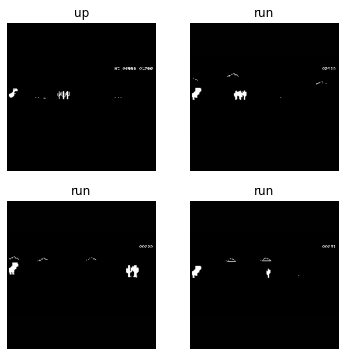

In [94]:
dls.valid.show_batch(max_n=4, nrows=2)

last image is caused by game background transition

In [95]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate, accuracy])

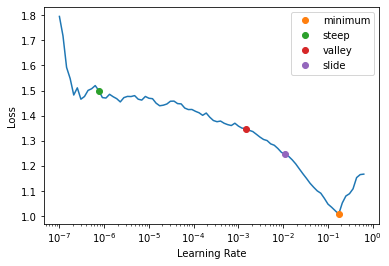

In [43]:
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

In [96]:
learn.fine_tune(10, base_lr=10e-03)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.783991,0.403572,0.091525,0.908475,02:25


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.290397,0.167760,0.067797,0.932203,03:11
1,0.225044,0.253771,0.076271,0.923729,03:08
2,0.199923,0.120682,0.064407,0.935593,03:07
3,0.178641,0.170688,0.074576,0.925424,03:08
4,0.149525,0.139999,0.062712,0.937288,03:12
5,0.127467,0.283184,0.069492,0.930508,03:03
6,0.102768,0.198880,0.066102,0.933898,03:08
7,0.084167,0.179888,0.054237,0.945763,03:06
8,0.062722,0.204327,0.064407,0.935593,02:55
9,0.044627,0.210475,0.066102,0.933898,02:55


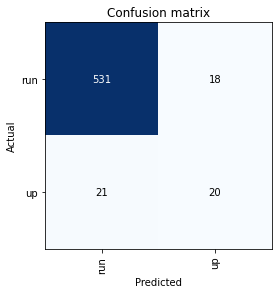

In [98]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [99]:
interp.print_classification_report()

              precision    recall  f1-score   support

         run       0.96      0.97      0.96       549
          up       0.53      0.49      0.51        41

    accuracy                           0.93       590
   macro avg       0.74      0.73      0.74       590
weighted avg       0.93      0.93      0.93       590



In [100]:
learn.export(os.path.abspath('models/v2.pkl'))

In [107]:
frame = cv2.imread('dataset/up/04-14-2022-02-00-50-789821.png');

In [108]:

learn.predict(frame)

('up', TensorBase(1), TensorBase([0.0047, 0.9953]))